# "Godzilla" Saharan Dust Radiative Transfer
### Paige Bartels
### 12/8/2023

### Content Introduction
This code utilizes the daily MERRA-2 (Modern-Era Retrospective analysis for Research and Applications, Version 2) data over the eastern Atlantic near Africa to analyze the thermodynamical impacts of Saharan Dust. The "Godzilla" June 2020 dust event was anomalous in how far the dust plume was transported, with Puerto Rico experiencing high aerosol optical depth values (poor air quality conditions) from this dust event.

MERRA-2 datasets are reanalysis, and have a daily temporal resolution. The spatial resolution is 0.5 degrees longitude by 0.5 degrees latitude. Two types of MERRA-2 datasets are utilized: PTQ (pressure, temperature, specific humidity, ozone), and AERO (dust mixing ratio, pressure). 

The Fu-Liou-Gu (FLG) Radiative Transfer Model run in this code was performed through FORTRAN. The text file outputs are imported in accordingly after the model run. The FLG model will return a text file with the shortwave, longwave, and total flux, along with each of the up and down components.

### Outline of Code
<h4><b>Section 0 - Reading in Data</b></h4>
<b>Section 0.0</b> - Importing packages <br>
<b>Section 0.1</b> - Importing MERRA-2 data and slicing by days, latitudes, and longitudes <b>(outside of notebook) </b> <br>
<b>Section 0.2</b> - Importing NetCDF4 files from sliced MERRA-2 dataset <br>

<h4><b>Section 1 - Writing Text Files for FLG Model</b></h4>
<b> Section 1.1</b> - Writing PTQ text file <br>
<b> Section 1.2</b> - Writing Extinction text file <br>
<h4><b>Section 2 - Running FLG Radiative Transfer Model</b></h4>
<b> Section 2.1</b> - Running FLG Radiative Transfer Model <b>(outside of notebook)</b> <br>
<b> Section 2.2</b> - Importing FLG text files

<h4><b>Section 3 - Plotting Radiative Transfer, Dust, Surface Temperature</b></h4>
<b> Section 3.1 </b>- Plotting Radiative Transfer <br>
<pre><b> Section 3.1.1</b> - Plotting No-Aerosol and Aerosol Radiative Transfer <br>
<b> Section 3.1.2</b> - Plotting the Difference in Radiation <br> </pre>
<b> Section 3.2</b> - Plotting Dust Location <br>
<b> Section 3.3</b> - Plotting Surface Temperature<br>
<h4><b> Section 4 - Writing the data into a NetCDF4 file</b></h4>

### Section 0.0
#### Importing Packages
This notebook uses variations of matplotlib, cartopy, xarray, numpy, and NetCDF4.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import xarray as xr

import numpy as np

from netCDF4 import Dataset

cartopy.config['data_dir']='./data'

cartopy.io.shapereader.natural_earth( \
  resolution='50m', \
  category='physical', \
  name='coastline')

cartopy.io.shapereader.natural_earth( \
  resolution='50m', \
  category='cultural', \
  name='admin_0_boundary_lines_land')

### Section 0.1
#### Importing MERRA-2 data and slicing by days, latitudes, and longitudes
This code is taken from a seperate notebook. Data for MERRA-2 Reanalysis can be found through NASA at <url>https://disc.gsfc.nasa.gov/datasets?project=MERRA-2</url> <br> <br>
The data used is taken from June 18, 2020, and the box used is from 40 E to 10 E, and from 0 N to 30 N.

### Section 0.2
#### Importing NetCDF4 files from sliced MERRA-2 dataset
The following datasets are opened via xarray

In [4]:
# Opens the PTQ dataset
dt=xr.open_dataset('./data/aos573_0618ptq.nc')

# Opens the AERO dataset
dd=xr.open_dataset('./data/aos573_0618dust.nc')

## Section 1: Writing Text Files for FLG Model

### Section 1.1
#### Writing PTQ Text File
For this FLG Radiative Transfer Model, the data from 1200 UTC will be used. The pressure profile for this dataset also needs to be calculated, since the dataset only includes arbitrary levels. I will also select a specific point, 15N 30E, which is almost in the center of the box. <br><br> In this section, I wrote three functions. The first, `calculate_pressure`, calculates the pressure profile from the given surface pressure and layer pressure thickness. The second, `calc_values`, finds each value at the latitude and longitude and prepares it to be written in a text file. The third, `write_ptq_txt`, writes the values into a .txt file for the FORTRAN script to understand.

In [3]:
def calculate_pressure(ps, delp):
    # Create empty array with each level
    P=np.zeros(72)
    
    # Setting the first level to equal the surface pressure
    P[0]=ps
    
    # For each ascending level
    for num in range(len(delp)-1):
        
        # The next pressure value should be previous value minus the difference in pressure
        P[num+1]=P[num]-delp[num]
        
    #Flipping the array to be from surface to TOA
    P=np.flip(P)
    return P

In [4]:
def calc_values(ds):    
    # Selecting Surface Pressure
    surf_pres=ds['PS'].sel(lat=15, lon=-30, method='nearest')
    
    # Selecting DELP (Layer Pressure Thickness, or the difference in pressure between levels)
    delp=ds['DELP'].sel(lat=15, lon=-30, method='nearest')
    
    # Selecting Temperature
    temp=ds['T'].sel(lat=15, lon=-30, method='nearest')
    
    # Selecting Ozone
    ozone=ds['O3'].sel(lat=15, lon=-30, method='nearest')
    
    # Selecting Specific Humidity (q)
    q=ds['QV'].sel(lat=15, lon=-30, method='nearest')
    
    # Converting pressure values from Pa to hPa
    ps=surf_pres/100
    delp=delp/100

    p=calculate_pressure(ps, delp)

    # Turning each variable into a numpy array to be read into a .txt file
    t=np.asfarray(temp)
    o3=np.asfarray(ozone)
    q=np.asfarray(q)

    # Adding a column of zeros for the FLG model
    zero=np.zeros(72)
    
    return p, t, o3, q, zero

In [5]:
def write_ptq_txt(p,t,o3,q,zero,doy):
    # writing the text file
    file=open('./data/dust_%03d_thermo.txt' %doy, 'w')

    for i in range(72): # writing one line per level, from surface to TOA
        # Column 1: Pressure (hPa)
        file.write(str(p[i]))
        file.write('\t')

        #Column 2: Temperature (Celsius)
        file.write(str(t[i]))
        file.write('\t')

        #Column 3: Specific Humidity (kg/kg)
        file.write(str(q[i]))
        file.write('\t')

        #Column 4: Ozone (kg/kg)
        file.write(str(o3[i]))
        file.write('\t')

        #Column 5: Zeros
        file.write(str(zero[i]))
        file.write('\n')

    file.close()

In [6]:
# Selecting the desired time from the dataset (12Z)
da = dt.sel(time = '2020-06-18T12:00:00.000000000')

# Selecting values
p, t, o3, q, zero = calc_values(da)

# Writing into a PTQ text file, with the day of year (DOY) at the end
write_ptq_txt(p, t, o3, q, zero, 170)

### Section 1.2
#### Writing Extinction Text File
The AERO files contain each dust mixing ratio (labeled as DU or DUMR). Each mixing ratio accounts for a different particle size, as labeled 1-5. The extinction is calculated from a pre-defined equation, dependent on each particle size and air density value.<br><br> This .txt file needs both a pressure profile and an extinction profile, and the PTQ and AERO files use the same pressure profile, so the pressure profile calculated in Section 1.1 can be used here. 

In [7]:
# Selecting the desired time (12Z)
df = dd.sel(time = '2020-06-18T12:00:00.000000000')

# Calculating the extinction coefficent for each dust particle size
ke_001 = (3 * df['DU001'] * 2.68) / (4 * 2500 * (0.73 * 1e-6))
ke_002 = (3 * df['DU002'] * 2.42) / (4 * 2650 * (1.4 * 1e-6))
ke_003 = (3 * df['DU003'] * 2.28) / (4 * 2650 * (2.4 * 1e-6))
ke_004 = (3 * df['DU004'] * 2.18) / (4 * 2650 * (4.5 * 1e-6))
ke_005 = (3 * df['DU005'] * 2.18) / (4 * 2650 * (8.0 * 1e-6))

# Calculating the extinciton for each particle size using the coefficient and air density
extinction_du001 = (ke_001 * df['AIRDENS']) * 1000
extinction_du002 = (ke_002 * df['AIRDENS']) * 1000
extinction_du003 = (ke_003 * df['AIRDENS']) * 1000
extinction_du004 = (ke_004 * df['AIRDENS']) * 1000
extinction_du005 = (ke_005 * df['AIRDENS']) * 1000

# Calculating the total extinction by summing the extinction from each particle size
total_extinction = (extinction_du001 + extinction_du002 + extinction_du003 + extinction_du004 + extinction_du005)
total_extinction = total_extinction.values

# Writing pressure and extinction to a text file
output_file = './data/dust_170_ext.txt'%dd

with open(output_file, 'w') as f:
    # Utilizing the pressure profile from Section 1.1
    for pres, ext in zip(p, total_extinction):
        # Writing the text file with pressure values in the first column, extinction in the second
        f.write(f'{pres} {ext}\n')

## Section 2: Running the FLG Radiative Transfer Model

### Section 2.1
#### Running the FLG Model in Fortran <b>(outside of notebook)</b>
The created text files are then imported into a FORTRAN code, which utilizes many parameters, such as: aerosol optical depth, cloudiness, the thermodynamic profile (which was in the PTQ text file), the extinction by altitude (which was in the extinction text file), the type of aerosol, the time and date, the location, and the sensor collecting the data.<br><br>

The code, comprised of three different files (table, the radiative transfer equations, and the data import), utilizes all three to output a text file, containing shortwave, longwave, and total heat fluxes. A no-aerosol run was completed to have control data to compare the outputs. After the code ran, the text files were imported back into the `/data` folder. The files are named `godzilla_aero_170.out` and `godzilla_noaero_170.out`, respectively. The naming convention is as follows: the name of the event (Godzilla), aerosol or no-aerosol, and day of year.


### Section 2.2
#### Importing the .out files into the notebook
Since the files are in the `/data` folder, we can easily import these files back into the notebook. The function provided, `read_rtm`, takes each text file and extracts the profiles from each column. The data must be seperated into a top and bottom section due to the formatting in the text file. It then transfers the data into an xarray file so the data will be easier to work with.

In [8]:
def read_rtm(file):
    # Reading in the data from the top half of the file (Heating)
    data_top = np.genfromtxt(file, skip_header=8, skip_footer=73)
    pressure = data_top[:, 0] 
    sw = data_top[:, 1]
    ir = data_top[:, 2]
    total_heating = data_top[:, 3]

    # Reading in the data from the bottom half of the file (Fluxes)
    data_bottom = np.genfromtxt(file, skip_header = 80)
    flux_pres = data_bottom[:, 0]
    flux_sw_down = data_bottom[:, 1]
    flux_sw_up = data_bottom[:, 2]
    flux_ir_up = data_bottom[:, 3]
    flux_ir_down = data_bottom[:, 4]

    ds = xr.Dataset(
        data_vars = {'sw':(['pres'], sw), 'ir':(['pres'], ir),'total_heat':(['pres'], total_heating),
                   'sw_down':(['flux_pres'], flux_sw_down),'sw_up':(['flux_pres'], flux_sw_up),
                   'ir_up':(['flux_pres'], flux_ir_up),'ir_down':(['flux_pres'], flux_ir_down)},
        coords = {'pres': pressure, 'flux_pres': flux_pres})
    
    return ds

In [9]:
noaero_ds = read_rtm('./data/godzilla_noaero_170.out')
aero_ds = read_rtm('./data/godzilla_aero_170.out')

## Section 3: Plotting Radiative Transfer, Dust, and Surface Temperature

### Section 3.1.1
#### Plotting the Radiative Transfer for the Aerosol and No-Aerosol Cases
The plots below will show the profile of the radiative heating for both the aerosol and no-aerosol case. Because the fluxes contribute to the overall heating, only the heating (top part of the .txt files) will be plotted for ease of interpretation and viewing.

Text(0.5, 0.98, 'June 18, 2020; Lat: 15N, Lon: 30E')

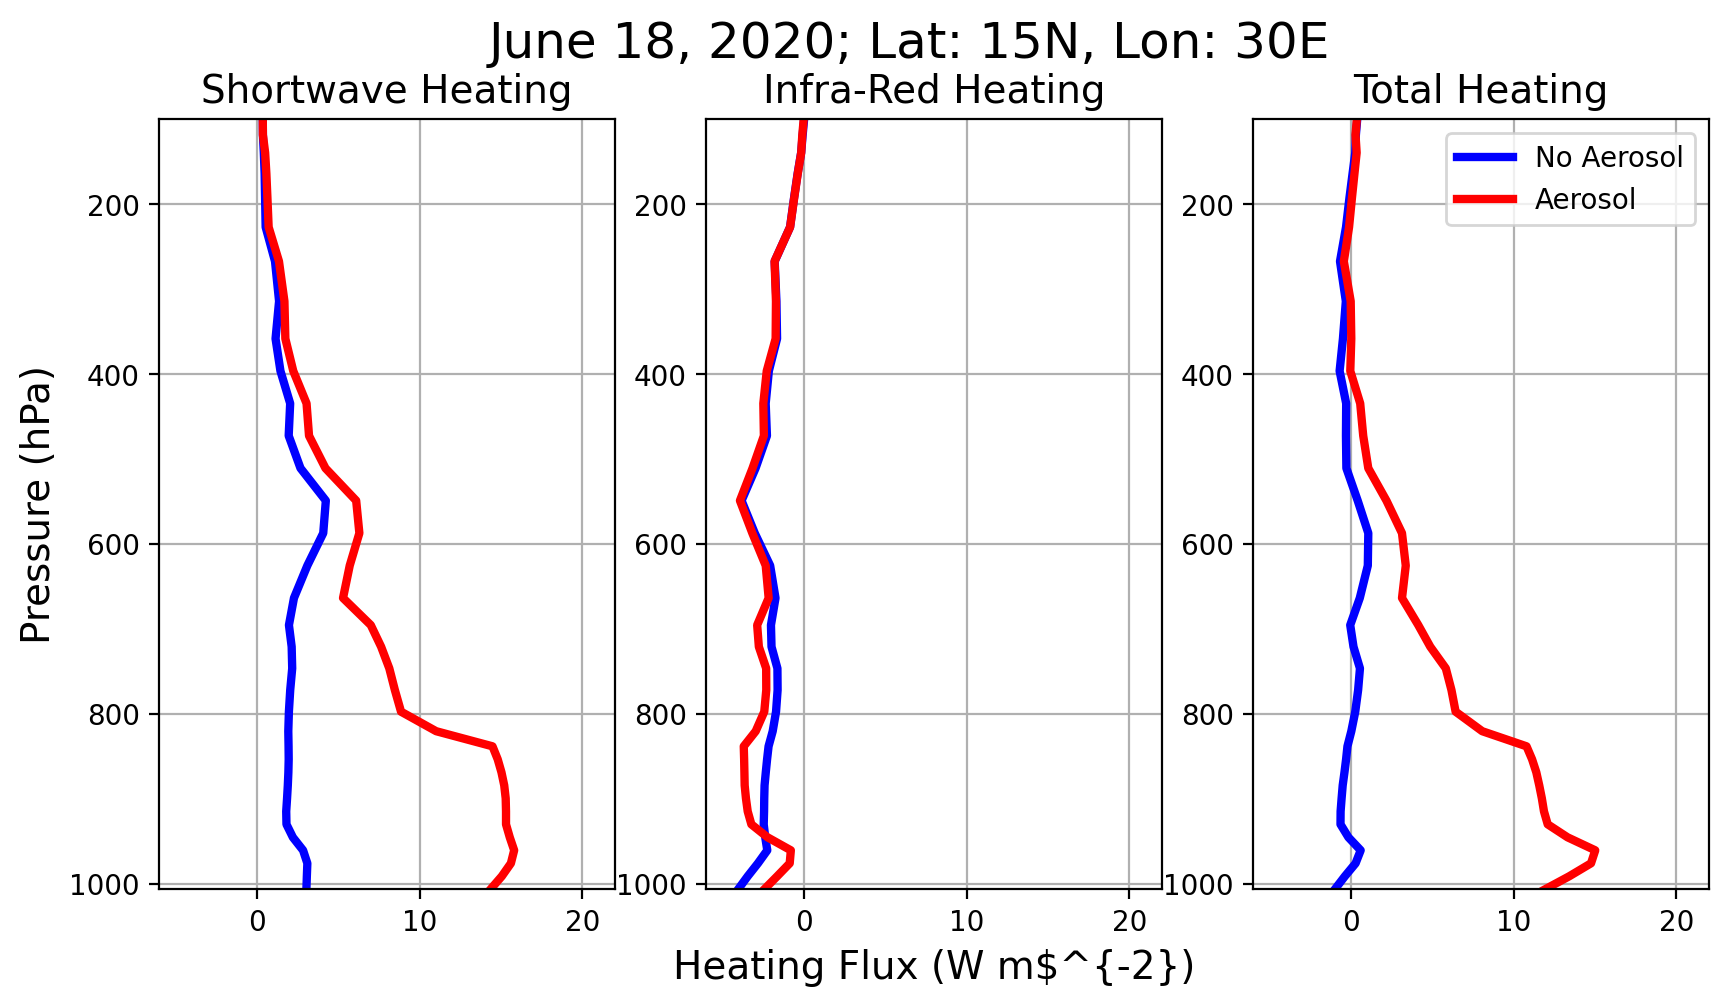

In [10]:
# Creating a figure and axes for a three-columned plot
fig = plt.figure(dpi = 200, figsize = (10, 5))
ax = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)


# Plotting the Shortwave Heating
ax.plot(noaero_ds['sw'], noaero_ds.pres, label = 'No Aerosol', linewidth = 3, color = 'blue')
ax.plot(aero_ds['sw'], aero_ds.pres, label = 'Aerosol', linewidth = 3, color = 'red')

# Setting the y limit until 100 hPa
ax.set_ylim(aero_ds['pres'].max(), 100)
# Setting a x limit for continuity between plots
ax.set_xlim(-6, 22)
# Setting a y axis pressure label
ax.set_ylabel('Pressure (hPa)', size = 14)
# Creating the title for the plot
ax.set_title('Shortwave Heating', size = 14)
# Creating a grid in the background
ax.grid()

# Plotting the Infra-Red Heating
ax2.plot(noaero_ds['ir'], noaero_ds.pres, label = 'No Aerosol', linewidth = 3, color = 'blue')
ax2.plot(aero_ds['ir'], aero_ds.pres, label = 'Aerosol', linewidth = 3, color = 'r')
# Setting the y limit until 100 hPa
ax2.set_ylim(aero_ds['pres'].max(), 100)
# Setting a x limit for continuity between plots
ax2.set_xlim(-6, 22)
# Setting a x axis flux label
ax2.set_xlabel(r"Heating Flux (W m$^{-2})", size = 14)
# Creating the title for the plot
ax2.set_title('Infra-Red Heating', size = 14)
# Creating a grid in the background
ax2.grid()

# Plotting the Total Heating
ax3.plot(noaero_ds['total_heat'], noaero_ds.pres, label = 'No Aerosol', linewidth = 3, color = 'blue')
ax3.plot(aero_ds['total_heat'], aero_ds.pres, label = 'Aerosol', linewidth = 3, color = 'r')
# Setting the y limit until 100 hPa
ax3.set_ylim(aero_ds['pres'].max(), 100)
# Setting a x limit for continuity between plots
ax3.set_xlim(-6, 22)
# Creating the title for the plot
ax3.set_title('Total Heating', size = 14)
# Creating a grid in the background
ax3.grid()

# Creating a legend
plt.legend()
# Creating a title with overall
plt.suptitle('June 18, 2020; Lat: 15N, Lon: 30E', size = 18)

### Section 3.1.2
#### Plotting Radiative Heating Difference
Now, using the datasets, we can subtract the no-aerosol case from the aerosol case to see the heating anomaly that the dust plume caused.

In [11]:
# Adding the figure and the axis for the plot
fig=plt.figure(figsize=(4,6))
ax=fig.add_subplot(1,1,1)

# Plotting the shortwave difference in light sea green
ax.plot(aero_ds['sw'] - noaero_ds['sw'], noaero_ds.pres, label = 'Shortwave', linewidth = 3, color = 'lightseagreen')
# Plotting the IR difference in purple (orchid)
ax.plot(aero_ds['ir'] - noaero_ds['ir'], noaero_ds.pres, label = 'Infra-Red', linewidth = 3, color = 'orchid')
# Plotting the total heat difference in blue
ax.plot(aero_ds['total_heat'] - noaero_ds['total_heat'], noaero_ds.pres, label = 'Total Heating', linewidth = 3, 
        color = 'blue')
# Plotting a vertical black line at 0
ax.axvline(x = 0, c = 'k')
# Setting the y limit to better show pressure values
ax.set_ylim(aero_ds['pres'].max(), 100)
# Setting the x limit to better show heating fluxes
ax.set_xlim(-6,15)
# Setting the x and y labels
ax.set_ylabel('Pressure (hPa)', size = 14)
ax.set_xlabel(r'Heating Rate (W m$^{-2}$)', size = 14)
# Adding the title
ax.set_title('Aerosol vs No-Aerosol Heating Difference', size = 14)
# Adding a grid
ax.grid()

# Adding a legend to the plot
plt.legend()
# Adding a suptitle with the date and location
plt.suptitle('June 18, 2020; Lat: 15N, Lon: 30E', size = 18)

Text(0.5, 0.98, 'June 18, 2020; Lat: 15N, Lon: 30E')

From this plot, we can analyze these results. The dust clearly has a heating difference on the atmosphere primarily below 600 hPa. The IR heating becomes inverted just above 900 hPa, meaning that the dust has a cooling effect between about 900-600 hPa. However, the primary heating component is in the shortwave, and it increases the total heating flux by almost 15 W m$^{-2}$

### Section 3.2
#### Plotting the Dust Plume
To visualize the extent of the dust plume, along with the location we just calculated the heating, let's plot a contour map of the dust plume at 12Z. We can do this by calculating the total dust mixing ratio.

Text(0.5, 0.98, '12Z June 18, 2020')

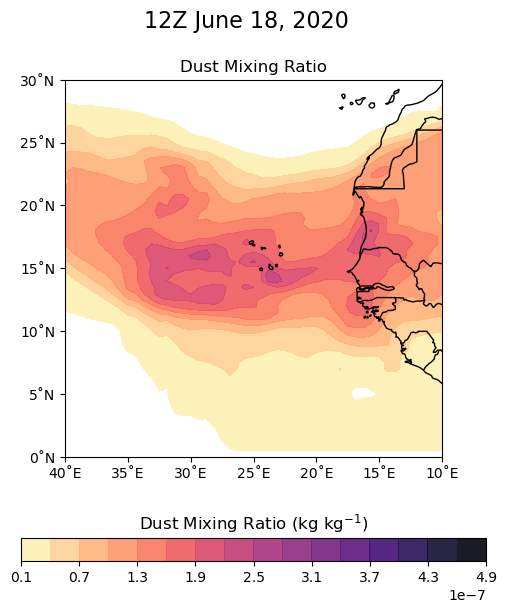

In [8]:
# Calculating the total dust mixing ratio
dd['DUMR'] =(dd['DU001'] + dd['DU002'] + dd['DU003'] + dd['DU004'] + dd['DU005']).mean(axis = 1)

# Setting the figure and axis for the plot
fig = plt.figure(figsize = (6, 7))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

# Setting the contour levels to be limited, plotting only regions of signficant dust
clev = np.arange(10e-9, 50e-8, 3e-8)

# Plotting the dust mixing ratio contours
merra_contours = ax.contourf(dd.lon, dd.lat, (dd['DUMR'].sel(time = '2020-06-18T12:00:00.000000000')),  
                           levels = clev, cmap = plt.cm.magma_r, transform = ccrs.PlateCarree(), alpha = 0.9)

#Adding borders and a coastline to the map
ax.add_feature(cfeature.BORDERS, zorder = 10)
ax.add_feature(cfeature.COASTLINE, zorder = 10)

# Setting X and Y ticks and labels to reflect longitude and latitude
ax.set_xticks(np.arange(-40, -9, 5))
ax.set_xticklabels(['40˚E', '35˚E', '30˚E', '25˚E', '20˚E', '15˚E', '10˚E'])
ax.set_yticks(np.arange(0, 31, 5))
ax.set_yticklabels(['0˚N', '5˚N', '10˚N', '15˚N', '20˚N', '25˚N', '30˚N'])

# Creating the colorbar
cb=plt.colorbar(merra_contours, orientation = 'horizontal')
cb.ax.set_title('Dust Mixing Ratio (kg kg$^{-1}$)', fontsize = 12) 

# Setting the titles
ax.set_title('Dust Mixing Ratio', size = 12)
plt.suptitle('12Z June 18, 2020', size = 16)

### Section 3.3
#### Plotting the Surface Temperature
Finally, to visually see some correlation with heating, we can look at the surface temperature. Because of MERRA-2's arbitrary levels, level 72 (the last one) will be the surface, with level 1 being the top of the atmosphere.

Text(0.5, 0.98, '12Z June 18, 2020')

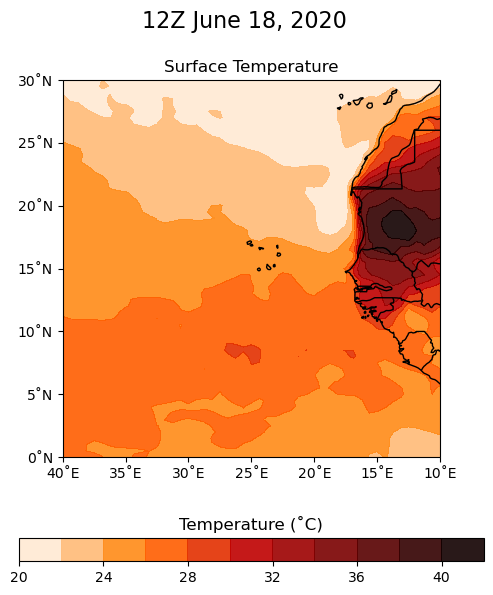

In [13]:
# Setting the figure and axis for the plot
fig=plt.figure(figsize = (6, 7))
ax=fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

# Setting the contour levels to be limited, plotting only regions of signficant dust
clev = np.arange(20, 44, 2)

# Plotting the surface temperature contours
temp_contours = ax.contourf(da.lon, da.lat, (da['T'].sel(lev = 72) - 273.15),  
                           levels = clev, cmap = plt.cm.gist_heat_r, transform = ccrs.PlateCarree(), alpha = 0.9)

#Adding borders and a coastline to the map
ax.add_feature(cfeature.BORDERS, zorder = 10)
ax.add_feature(cfeature.COASTLINE, zorder = 10)

# Setting X and Y ticks and labels to reflect longitude and latitude
ax.set_xticks(np.arange(-40, -9, 5))
ax.set_xticklabels(['40˚E', '35˚E', '30˚E', '25˚E', '20˚E', '15˚E', '10˚E'])
ax.set_yticks(np.arange(0, 31, 5))
ax.set_yticklabels(['0˚N', '5˚N', '10˚N', '15˚N', '20˚N', '25˚N', '30˚N'])

# Creating the colorbar
cb=plt.colorbar(temp_contours, orientation = 'horizontal')
cb.ax.set_title('Temperature (˚C)', fontsize = 12) 

# Setting the titles
ax.set_title('Surface Temperature', size = 12)
plt.suptitle('12Z June 18, 2020', size = 16)

## Section 4 - Writing Output into a NetCDF4 file
In this final section, we will write the FLG radiative transfer outputs from the aerosol file into a NetCDF4 file so it can be reused and distributed.

<b>Note: if this NetCDF file is already created, it cannot be overridden. The original file must be deleted before rerunning the code.</b>

In [17]:
# Creating a file name along with the path
fn = "./data/merra2-flg-20200618.nc"

# Creating the NetCDF dataset
f = Dataset(fn, 'w', format='NETCDF4')

# Creating the dimesions for the dataset
f.createDimension('pressure', len(aero_ds['pres']))

# Creating empty variables in the dataset along with the dimensions
pressure = f.createVariable('pressure', 'f4', ('pressure'))
sw = f.createVariable('shortwave_heat', 'f4', ('pressure'))
ir = f.createVariable('infrared_heat', 'f4', ('pressure'))
total = f.createVariable('total_heat', 'f4', ('pressure'))

# Writing the variables into the dataset
pressure[:]=aero_ds['pres']
sw[:]=aero_ds['sw']
ir[:]=aero_ds['ir']
total[:]=aero_ds['total_heat']

# Adding global attributes
f.file_type = "MERRA2-Reanalysis-FLG-Heating"
f.version = "1.0"
f.year = "2020"
f.month = "06"
f.day = "18"

# Adding appropriate descriptions to each variable
pressure.description = 'Vertical pressure levels'
sw.description = 'Shortwave heating profile with aerosols'
ir.description = 'Infrared heating profile with aerosols'
total.description = 'Total heating profile with aerosols'

# Closing the NetCDF4 writer
f.close()